In [ ]:
#Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

In [ ]:
#Downloading the data
df = yf.download('AAPL', start='2012-01-01', end='2023-05-19')

# We'll use 'Close' price for prediction
data = df.filter(['Close'])

# Convert data to numpy array
dataset = data.values

# Get the number of rows to train the model on (80% of the data)
training_data_len = int(np.ceil(len(dataset) * .8))


[*********************100%***********************]  1 of 1 completed


In [ ]:
#Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)


In [ ]:
#Create the training data set
train_data = scaled_data[0:int(training_data_len), :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])


In [ ]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data (LSTM expects a 3-dimensional input)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [ ]:
#Build the GRU model
model = Sequential()
model.add(GRU(50, return_sequences=False, input_shape=(x_train.shape[1], 1)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
2231/2231 [==============================] - 23s 10ms/step - loss: 2.3567e-04
Epoch 2/5
2231/2231 [==============================] - 20s 9ms/step - loss: 1.1432e-04
Epoch 3/5
2231/2231 [==============================] - 20s 9ms/step - loss: 9.3669e-05
Epoch 4/5
2231/2231 [==============================] - 20s 9ms/step - loss: 8.1779e-05
Epoch 5/5
2231/2231 [==============================] - 20s 9ms/step - loss: 8.2052e-05


In [ ]:
#Create the testing data set
test_data = scaled_data[training_data_len - 60:, :]

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))


In [ ]:
#Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) # Undo scaling


18/18 [==============================] - 0s 6ms/step


<ipython-input-11-0afc4f40c08d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


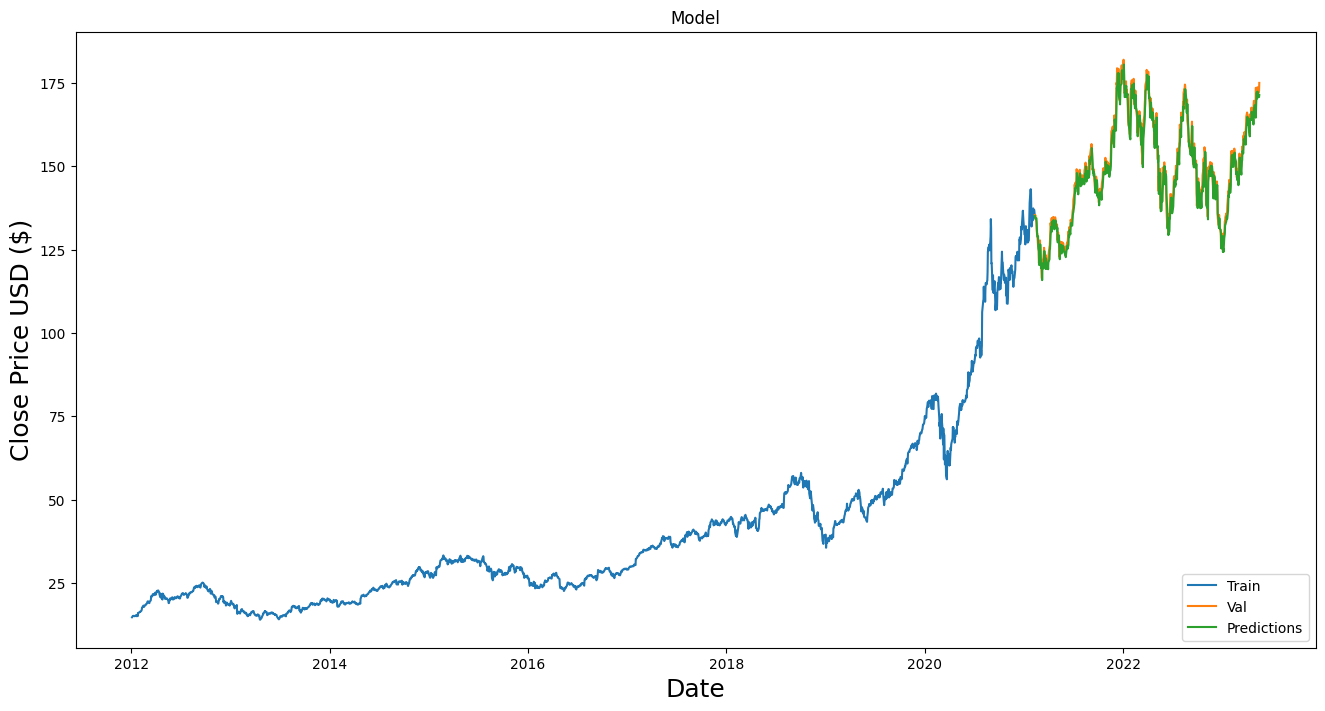

In [ ]:
#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


In [ ]:
#Show the actual and predicted prices
valid


,Close,Predictions
Date,,
2021-02-10,135.389999,135.109711
2021-02-11,135.130005,134.489548
2021-02-12,135.369995,134.228088
2021-02-16,133.190002,134.441132
2021-02-17,130.839996,132.369766
...,...,...
2023-05-12,172.570007,172.440002
2023-05-15,172.070007,171.239380
2023-05-16,172.070007,170.775665


In [ ]:
#Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(valid['Close'], valid['Predictions'])
print(f"MSE: {mse}")


MSE: 8.98960470706027
